In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

In [2]:
temp = 298  # kelvin
pres = 1e5  # Pascals
Rgas = 8.314  # J/(mol-K)
avo = 6.022e23

PHOx = 0.1  # pptv/s
k1 = 26.3e-12
k2 = 7.7e-12
k3 = 8.1e-12
k4 = 1.1e-11
k5 = 2.9e-12
k6 = 5.2e-12
k7 = 0.015  # s-1
k8 = 1.9e-14

airden = (pres * avo) / (Rgas * temp * 1e6)  # molec/cm3
ppbfac = 1e9 / airden

def myfun(t, u):
    f = np.zeros(7)
    f[0] = -k2 * u[3] * u[0] + k7 * u[1] - k8 * u[5] * u[0] - k3 * u[4] * u[0]
    f[1] = k2 * u[3] * u[0] + k3 * u[4] * u[0] + k8 * u[5] * u[0] - k7 * u[1] - k4 * u[2] * u[1]
    f[2] = -k1 * u[6] * u[2] + k3 * u[4] * u[0] - k4 * u[2] * u[1] + PHOx * 1e-12 * airden
    f[3] = k1 * u[6] * u[2] - k2 * u[3] * u[0] - k6 * u[3] * u[4]
    f[4] = k2 * u[3] * u[0] - k3 * u[4] * u[0] - 2 * k5 * u[4] ** 2 - k6 * u[3] * u[4]
    f[5] = k7 * u[1] - k8 * u[5] * u[0]
    f[6] = -k1 * u[6] * u[2]
    return f

In [6]:
def calculate_max_o3(nox, rh):
    Cnox = nox * 1e-9 * airden
    Crh = rh * 1e-9 * airden
    u0 = np.zeros(7)
    u0[0] = Cnox * (2 / 3)  
    u0[1] = Cnox * (1 / 3) 
    u0[6] = Crh
    time_span = (0, 6 * 3600)  # Simulate for 6 hours
    time_eval = np.arange(0, 6 * 3600, 300)  # Evaluate every 5 minutes
    sol = solve_ivp(myfun, time_span, u0, method='RK45', t_eval=time_eval)
    max_o3 = np.max(sol.y[2]) * ppbfac  # Convert to ppb
    return max_o3
    
nox_range = np.linspace(0, 50, 10)  # NOx in ppb
rh_range = np.linspace(50, 500, 10)  # RH in ppb
NOX, RH = np.meshgrid(nox_range, rh_range)
MAX_O3 = np.zeros_like(NOX)

for i in range(NOX.shape[0]):
    for j in range(NOX.shape[1]):
        MAX_O3[i, j] = calculate_max_o3(NOX[i, j], RH[i, j])

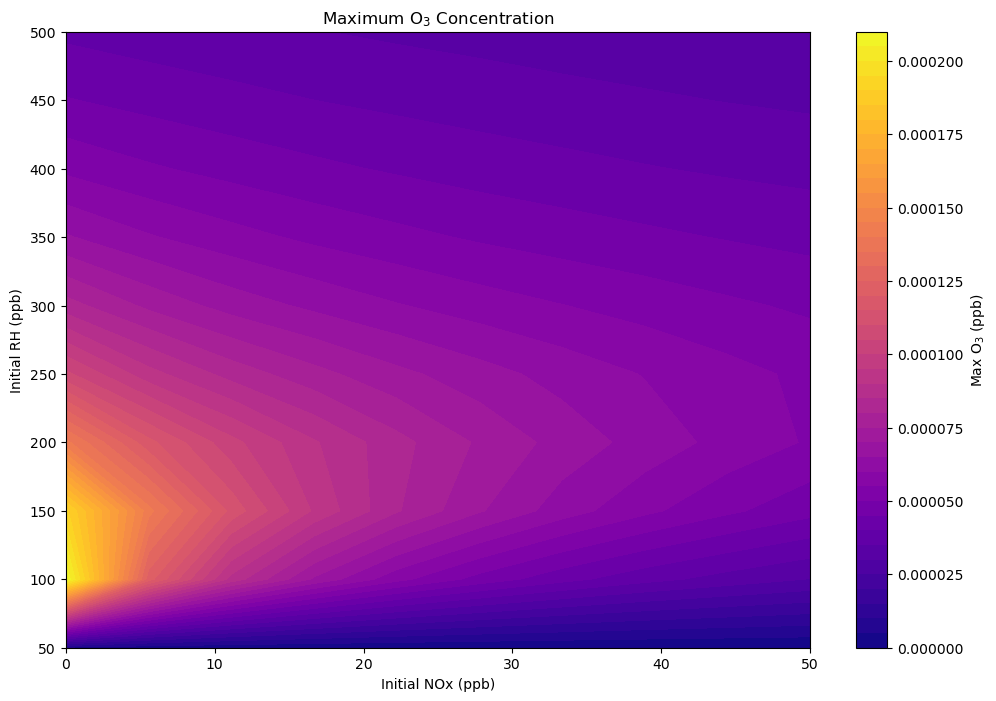

In [8]:
plt.figure(figsize=(12, 8))
contour = plt.contourf(NOX, RH, MAX_O3.T, levels=50, cmap="plasma")
plt.colorbar(contour, label="Max O$_3$ (ppb)")
plt.title("Maximum O$_3$ Concentration")
plt.xlabel("Initial NOx (ppb)")
plt.ylabel("Initial RH (ppb)")
plt.show()